In [45]:
from publicdata import client as c

In [46]:
print(c.iam.token.inspect())

{
    "subject": "XdSezXUzHbURkBoEJbrse8UMxTm3V4_QkXj2HEADs_A",
    "projects": [
        {
            "url_name": "de-transformations",
            "groups": [
                3974891759857484
            ]
        },
        {
            "url_name": "cdf-fundamentals",
            "groups": [
                7233047623736400
            ]
        },
        {
            "url_name": "publicdata",
            "groups": [
                1701516184810448,
                4860375157547584
            ]
        },
        {
            "url_name": "infield-training",
            "groups": [
                1376085367190226
            ]
        }
    ],
    "capabilities": [
        {
            "assetsAcl": {
                "actions": [
                    "READ",
                    "WRITE"
                ],
                "scope": {
                    "all": {}
                }
            },
            "projectScope": {
                "projects": [
                    "de-t

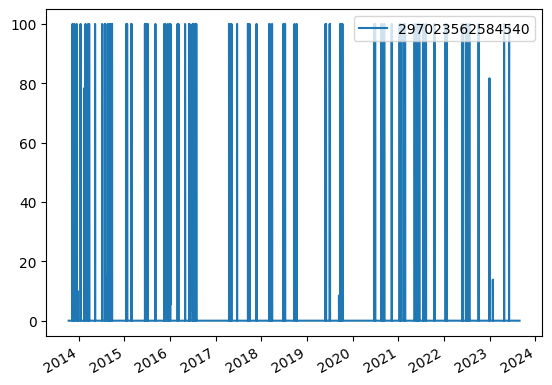

In [79]:
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import pandas as pd

pd.options.display.max_rows = 9999

df = c.time_series.data.retrieve_dataframe(
    id=297023562584540,
    end="now",
    column_names="id")


# print(df)

df.plot()
plt.show()
